# Unconditional Audio Synthesization using a Wasserstein Generative Adversarial Network

### Import dependencies

In [1]:
import tensorflow as tf #open-source ml library 
from tensorflow import keras #api to handle all the neural network stuff
from tensorflow.keras import layers #to add specific layers to networks
import matplotlib.pyplot as plt #to plot images
import numpy as np #to process tensor data
import soundfile as sf #to save audio arrays into files
from pydub import AudioSegment #to amplify generated audio
from IPython.display import Audio #to play audio
import librosa #to convert audio to image
from tqdm import tqdm #progress bar
import warnings #to block warnings
warnings.filterwarnings("ignore")

2024-04-13 00:11:06.085266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 00:11:06.085361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 00:11:06.208900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Constants

In [2]:
BATCH_SIZE = 16
IMG_SHAPE = (256, 256, 1)
noise_dim = 128

### Audio Processing Class

In [3]:
class Mel:
    def __init__(self, x_res=256, y_res=256, sample_rate=22050, n_fft=2048, hop_length=512, top_db=80, n_iter=32):
        #initialize parameters
        """
        x_res: width of resulting spectrogram image
        y_res: height of resulting spectrogram image
        """
        self.hop_length = hop_length #number of samples between successive frames
        self.sr = sample_rate #sampling rate of audio
        self.n_fft = n_fft #number of fft components
        self.top_db = top_db #top decibel amount in spectrogram 
        self.n_iter = n_iter #number of iterations for the Griffin-Lim algorithm
        self.set_resolution(x_res, y_res) 
        self.audio = None #initialize audio

    #set resolution
    def set_resolution(self, x_res, y_res):
        self.x_res = x_res
        self.y_res = y_res
        self.n_mels = self.y_res #number of mel bands in spectrogram
        self.slice_size = self.x_res * self.hop_length - 1 #size of an audio slice on the spectrogram
    
    #loads audio from file
    def load_audio(self, audio_file=None, raw_audio=None):
        if audio_file is not None:
            #using librosa and loading audio, given sample size
            self.audio, _ = librosa.load(audio_file, mono=True, sr=self.sr)
        else:
            self.audio = raw_audio

        if len(self.audio) < self.x_res * self.hop_length:
            #add padding if the length of audio doesn't match up with the expected length 
            self.audio = np.concatenate([self.audio, np.zeros((self.x_res * self.hop_length - len(self.audio),))])

    #returns number of slices in audio        
    def get_number_of_slices(self):
        return len(self.audio) // self.slice_size

    #returns a specific audio slice
    def get_audio_slice(self, slice=0):
        return self.audio[self.slice_size * slice : self.slice_size * (slice + 1)]

    #converts audio slice to image, or in our case audio to image
    def audio_slice_to_image(self, slice, ref=np.max):
        #get mel spectrogram of audio
        S = librosa.feature.melspectrogram(
            y=self.get_audio_slice(slice), sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels
        )
        #convert spectrogram to decibels and specify the top decibel
        log_S = librosa.power_to_db(S, ref=ref, top_db=self.top_db)
        #compress and clip the db spectrogram into suitable range for image
        bytedata = (((log_S + self.top_db) * 255 / self.top_db).clip(0, 255) + 0.5).astype(np.uint8)
        #convert array into image and return
        image = Image.fromarray(bytedata)
        return image

    #converts audio to tensor
    def audio_slice_to_vector(self, slice, ref=np.max):
        S = librosa.feature.melspectrogram(
            y=self.get_audio_slice(slice), sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels
        )
        log_S = librosa.power_to_db(S, ref=ref, top_db=self.top_db)
        byte_data = (((log_S + self.top_db) * 255 / self.top_db).clip(0, 255) + 0.5).astype(np.uint8)
        return byte_data.reshape(256, 256, 1)
    
    #converts from an image back to audio, reversing the process for converting audio to image
    def image_to_audio(self, image):
        bytedata = np.frombuffer(image.tobytes(), dtype="uint8").reshape((image.height, image.width))
        log_S = bytedata.astype("float") * self.top_db / 255 - self.top_db
        S = librosa.db_to_power(log_S)
        audio = librosa.feature.inverse.mel_to_audio(
            S, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_iter=self.n_iter
        )
        return audio
    
    #converts tensor to audio
    def vector_to_audio(self, vector):
        bytedata = vector.reshape(256, 256)
        log_S = bytedata.astype("float") * self.top_db / 255 - self.top_db
        S = librosa.db_to_power(log_S)
        audio = librosa.feature.inverse.mel_to_audio(
            S, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_iter=self.n_iter
        )
        return audio

### Convert Audio Segments to Tensor (Optional)
For context, first I used yt-dlp to get the lofi music file from a youtube URL. Then I used ffmpeg to split it into 5s chunks.

In [ ]:
mel = Mel(x_res=256, y_res=256, sample_rate=22050) #mel instance
'''
direc = os.listdir("/kaggle/input/ai-club-project-files/output_segments/output_segments") #directory with files
db = np.empty((len(direc), 256, 256, 1), dtype=np.uint8) #empty tensor for spectograms
#iterate through all the files
for i, file in tqdm(enumerate(direc), total=len(direc)): 
    #load the audio
    mel.load_audio("/kaggle/input/ai-club-project-files/output_segments/output_segments/" + file)
    y = mel.audio_slice_to_vector(slice=0) #convert to tensor
    db[i] = y #save in array
np.save("normed_songs.npy", db) #save array
'''

### Load back input data

In [5]:
train_images = np.load('/kaggle/input/ai-club-project-files/normed_songs/normed_songs.npy')
print(train_images.shape) 

(4706, 256, 256, 1)


### Display sample spectogram

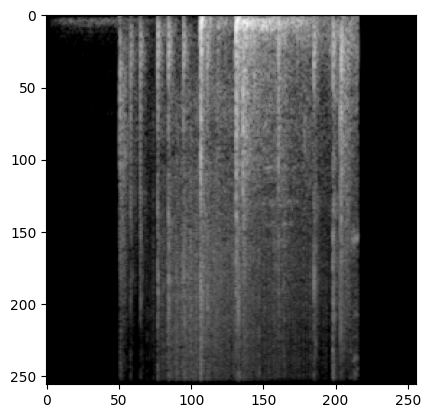

In [22]:
plt.imshow(train_images[0], cmap='gray')
plt.show()

### Normalize between [-1, 1]

In [7]:
train_images = (train_images - 127.5) / 127.5

### Define Downsample Block

In [8]:
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", 
               use_bias=True, use_bn=False, use_dropout=False, drop_value=0.5):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
        
    return x

### Define Upsample Block

In [9]:
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same",
                   use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
    
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
        
    return x

### Generator Model

In [10]:
def get_generator_model():
    #define input to be the noise dim
    noise = layers.Input(shape=(noise_dim,))
    #reshape to 8x8x1024 to pass into upsample blocks
    x = layers.Dense(8 * 8 * 1024, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((8, 8, 1024))(x)
    #8x8x1024 --> 16x16x512
    x = upsample_block(x, 512, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True, padding="same", use_dropout=False)
    #16x16x512 --> 32x32x256
    x = upsample_block(x, 256, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True, padding="same", use_dropout=False)
    #32x32x256 --> 64x64x128
    x = upsample_block(x, 128, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True, padding="same", use_dropout=False)
    #64x64x126 --> 128x128x64
    x = upsample_block(x, 64, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True, padding="same", use_dropout=False)
    #128x128x64 --> 256x256x1
    x = upsample_block(x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True)
    #define model
    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

g_model = get_generator_model()
g_model.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 65536)          │     8,388,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 65536)          │       262,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 1024)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 512)    │     4,718,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,922,052 (56.92 MB)

 Trainable params: 14,789,058 (56.42 MB)

 Non-trainable params: 132,994 (519.51 KB)

### Discriminator Model

In [11]:
def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    #256x256x1 --> 128x128x64
    x = conv_block(img_input, 64, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)
    #128x128x64 --> 64x64x128
    x = conv_block(x, 128, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, activation=layers.LeakyReLU(0.2), use_dropout=True, drop_value=0.3)
    #64x64x128 --> 32x32x256
    x = conv_block(x, 256, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, activation=layers.LeakyReLU(0.2), use_dropout=True, drop_value=0.3)
    #32x32x256 --> 16x16x512
    x = conv_block(x, 512, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)
    #flatten and output score
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 512)    │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,434,433 (16.92 MB)

 Trainable params: 4,434,433 (16.92 MB)

 Non-trainable params: 0 (0.00 B)

### WGAN Model

In [13]:
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, 
                 discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN, self).__init__()
        #initialize parameters 
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim #noise vector size
        self.d_steps = discriminator_extra_steps #number of times discriminator runs vs generator
        self.gp_weight = gp_weight #weight of gradient penalty term
    #compile function, takes in both optimizers and loss functions
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0) #used to interpolate between real and fake images
        diff = fake_images - real_images #difference in real and fake images
        interpolated = real_images + alpha * diff #creates interpolated images
        
        #record operations to compute gradients
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated) 
            #make discriminator prediction on interpolated images
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0] #gradient of discriminator's predictions with respect to interpolated images
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3])) #calculates euclidean norm of gradients
        gp = tf.reduce_mean((norm - 1.0) ** 2) #calculates gradient penalty
        return gp
    def train_step(self, real_images):
        #deal with tuples
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        #get batch size by looking at axis 0
        batch_size = tf.shape(real_images)[0]
        
        #train discriminator d_steps times
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            ) #generate noise
            #tape for calculating gradients
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True) #generate fake images
                #get discriminator predictions on fake images
                fake_logits = self.discriminator(fake_images, training=True) 
                #get discriminator predictions on real images
                real_logits = self.discriminator(real_images, training=True)
                #calculate normal loss, just like a GAN
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                #find gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                #add back to loss
                d_loss = d_cost + gp * self.gp_weight
            #find gradient using loss and parameters
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            #apply the gradients to model
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        #generate noise
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True) #get generated images
            #get discriminator predictions on fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            #calculate generator loss using them
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"d_loss": d_loss, "g_loss": g_loss} #return losses

### Directory for generated images (Optional)

In [14]:
!mkdir generated_images

### Generate images while Training

In [15]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        #define parameters
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim)) #generate noise
        generated_images = self.model.generator(random_latent_vectors) #generate images
        generated_images = (generated_images * 127.5) + 127.5 #normalize 
        #convert into image and save 
        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("/kaggle/working/generated_images/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

### Optimizers and Loss Functions

In [16]:
generator_optimizer = keras.optimizers.Adam(
	learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

### Initialize model

In [17]:
epochs = 30

cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

wgan = WGAN(discriminator=d_model,
			generator=g_model,
            latent_dim=noise_dim,
            discriminator_extra_steps=3)

### Compile and train model (Optional)

In [ ]:
'''
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
wgan.save_weights('lofi_gen.weights.h5')
'''

### Load pre-trained weights

In [18]:
wgan.load_weights("/kaggle/input/ai-club-project-files/lofi_gen.weights.h5")

### Generate Sample Spectogram

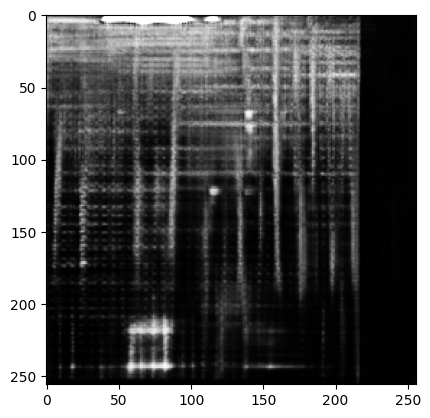

In [19]:
random_latent_vectors = tf.random.normal(shape=(1, noise_dim)) 
generated_images = wgan.generator(random_latent_vectors, training=False) 
generated_images = (generated_images * 127.5) + 127.5 
#display image
plt.imshow(generated_images[0], cmap='gray')
plt.show()

### Create function to generate audio

In [20]:
def generate():
    random_latent_vectors = tf.random.normal(shape=(1, noise_dim))
    generated_images = wgan.generator(random_latent_vectors, training=False)
    generated_images = (generated_images * 127.5) + 127.5
    #use mel to generate into audio
    aud = mel.vector_to_audio(np.array(generated_images[0], dtype=np.uint8))
    #save to file
    sf.write("gened_aud.wav", aud, 22050)
    #load back and amplify the audio
    audio = AudioSegment.from_wav("/kaggle/working/gened_aud.wav")
    amplified_audio = audio + 25  
    #resave
    amplified_audio.export(f"gened_aud_ampl.wav", format="wav")

### Play Generated Audio

In [24]:
generate()
Audio("/kaggle/working/gened_aud_ampl.wav", autoplay=True) #play the audio from file